In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Cài đặt các thư viện cần thiết
!pip install rasterio
!pip install earthpy
!pip install scikit-learn
!pip install tensorflow

# Import các thư viện
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import earthpy.plot as ep
from rasterio.plot import show
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from matplotlib.colors import ListedColormap, BoundaryNorm
import tensorflow as tf

# Kiểm tra GPU
print("GPU:", tf.config.list_physical_devices('GPU'))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 25.0 MB/s eta 0:00:00a 0:00:01
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Đường dẫn tới file dữ liệu mẫu
SAMPLE_PATH = '/kaggle/input/dataupdate2chisocanbang/dataCanBangNewUpdate2chiSo.csv'

# Đọc dữ liệu mẫu
samples = pd.read_csv(SAMPLE_PATH)

# Hiển thị một vài dòng dữ liệu
print("Sample data:")
print(samples.shape)


Sample data:
(109017, 23)


In [14]:
# Danh sách các đặc trưng (loại bỏ 'B1', 'Long', 'Lat')
FEATURES = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A',
            'B9', 'B10', 'B11', 'B12', 'NDVI', 'NDWI', 'NDBI', 'NDMI', 'BSI', 'EVI', 'SAVI']

# Loại bỏ cột 'B1', 'Long', và 'Lat' khỏi DataFrame
samples = samples.drop(columns=['B1', 'Long', 'Lat'])
LABEL = 'label'# Khởi tạo LabelEncoder
le = LabelEncoder()

# Áp dụng LabelEncoder cho cột 'label'
samples['label_encoded'] = le.fit_transform(samples[LABEL])

# Lưu lại mapping giữa nhãn và số
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapping giữa nhãn và số:", label_mapping)

# Số lượng lớp
N_CLASSES = len(label_mapping)
print(N_CLASSES)
# Tính toán class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(samples['label_encoded']),
    y=samples['label_encoded']
)

class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)
# Chia dữ liệu thành tập train và test
train, test = train_test_split(samples, test_size=0.2, random_state=42, stratify=samples['label_encoded'])

# Hiển thị số lượng mẫu trong mỗi tập
print(f"Số lượng mẫu trong tập train: {len(train)}")
print(f"Số lượng mẫu trong tập test: {len(test)}")
# Chuẩn bị dữ liệu cho chuẩn hóa
scaler = StandardScaler()

# Áp dụng scaler cho các đặc trưng
train_features = scaler.fit_transform(train[FEATURES])
test_features = scaler.transform(test[FEATURES])
# Chuyển đổi nhãn thành one-hot encoding
train_labels = to_categorical(train['label_encoded'], N_CLASSES)
test_labels = to_categorical(test['label_encoded'], N_CLASSES)
# Reshape dữ liệu cho CNN
def reshape_input(array):
    return array.reshape(array.shape[0], array.shape[1], 1)

train_input = reshape_input(train_features)
test_input = reshape_input(test_features)

# Hiển thị kích thước dữ liệu
print(f'Train features: {train_input.shape}')
print(f'Test features: {test_input.shape}')
print(f'Train labels: {train_labels.shape}')
print(f'Test labels: {test_labels.shape}')


KeyError: "['B1', 'Long', 'Lat'] not found in axis"

In [4]:
from tensorflow.keras.layers import GlobalAveragePooling1D
# Định nghĩa input_shape
input_shape = (train_input.shape[1], train_input.shape[2])


model = Sequential([
    Input(shape=input_shape),
    Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    Conv1D(128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(256, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    Conv1D(256, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),

    GlobalAveragePooling1D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dropout(0.2),
    Dense(N_CLASSES, activation='softmax')
])


# Hiển thị tóm tắt mô hình
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 19, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 19, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 19, 64)         │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 19, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 9, 128)         │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 9, 128)         │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 9, 128)         │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 4, 256)         │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 4, 256)         │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             

 Total params: 776,390 (2.96 MB)

 Trainable params: 773,574 (2.95 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [5]:
# Khởi tạo optimizer
optimizer = Adam(learning_rate=1e-3)

# Sử dụng focal loss (tuỳ chọn)
# from tensorflow.keras.losses import CategoricalCrossentropy
# loss_fn = CategoricalCrossentropy()
# Hoặc bạn có thể sử dụng focal loss bằng cách cài đặt thêm thư viện

# Biên dịch mô hình
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Định nghĩa các callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# Huấn luyện mô hình
history = model.fit(
    x=train_input,
    y=train_labels,
    validation_data=(test_input, test_labels),
    epochs=40,
    batch_size=2048,  # Sử dụng batch size lớn để tận dụng GPU P100
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/40


I0000 00:00:1732331003.765637     121 service.cc:145] XLA service 0x79443c008e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732331003.765778     121 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 5/43 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4123 - loss: 2.1068 

I0000 00:00:1732331014.036809     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


43/43 ━━━━━━━━━━━━━━━━━━━━ 26s 259ms/step - accuracy: 0.6667 - loss: 1.0917 - val_accuracy: 0.1725 - val_loss: 1.7752 - learning_rate: 0.0010
Epoch 2/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8242 - loss: 0.5086 - val_accuracy: 0.1817 - val_loss: 1.8775 - learning_rate: 0.0010
Epoch 3/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8433 - loss: 0.4459 - val_accuracy: 0.2075 - val_loss: 1.8857 - learning_rate: 0.0010
Epoch 4/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8574 - loss: 0.3996 - val_accuracy: 0.1779 - val_loss: 1.9728 - learning_rate: 5.0000e-04
Epoch 5/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8625 - loss: 0.3837 - val_accuracy: 0.1895 - val_loss: 2.0097 - learning_rate: 5.0000e-04
Epoch 6/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8699 - loss: 0.3630 - val_accuracy: 0.2861 - val_loss: 1.7606 - learning_rate: 2.5000e-04
Epoch 7/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8721 - loss: 0.3550 - val_

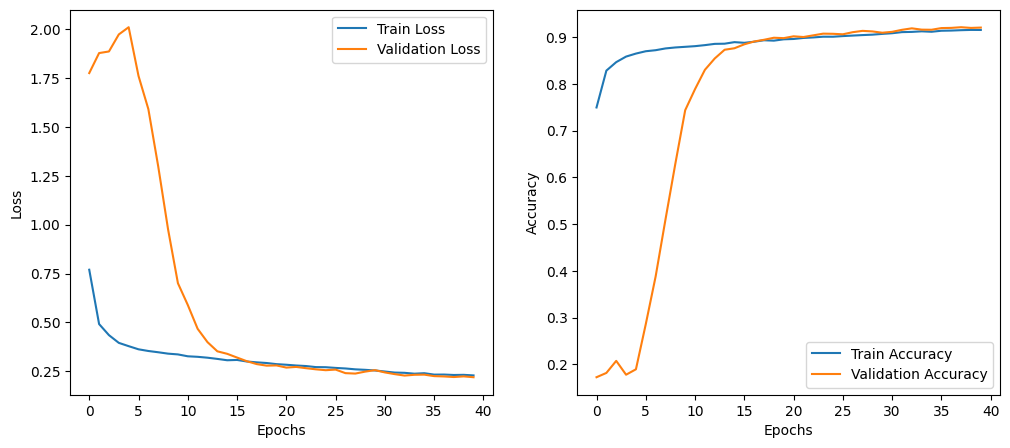

In [6]:
# Vẽ biểu đồ loss và accuracy
plt.figure(figsize=(12, 5))

# Biểu đồ loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Biểu đồ accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


682/682 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


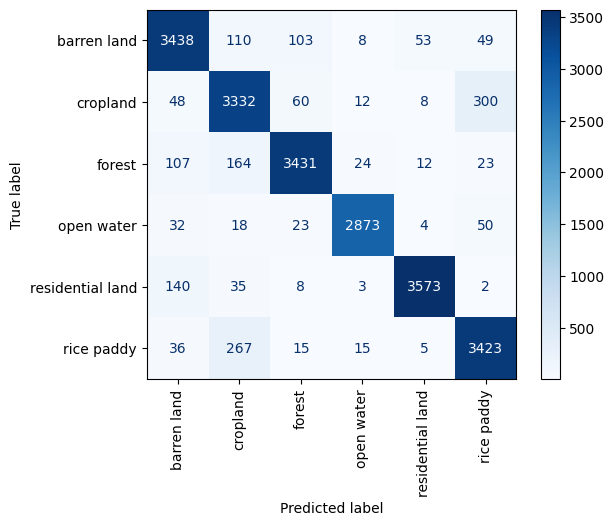

In [7]:
# Dự đoán trên tập test
test_predictions = model.predict(test_input)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)

# Ma trận nhầm lẫn
cm = confusion_matrix(test_true_labels, test_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()


In [8]:
# Báo cáo phân loại
print("Classification Report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=le.classes_))


Classification Report:
                  precision    recall  f1-score   support

     barren land       0.90      0.91      0.91      3761
        cropland       0.85      0.89      0.87      3760
          forest       0.94      0.91      0.93      3761
      open water       0.98      0.96      0.97      3000
residential land       0.98      0.95      0.96      3761
      rice paddy       0.89      0.91      0.90      3761

        accuracy                           0.92     21804
       macro avg       0.92      0.92      0.92     21804
    weighted avg       0.92      0.92      0.92     21804



Image dimensions: 1839 x 1547
Number of bands: 13
348/348 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Giá trị của N_CLASSES trước khi thêm undefined: 6
Giá trị của N_CLASSES sau khi thêm undefined: 7


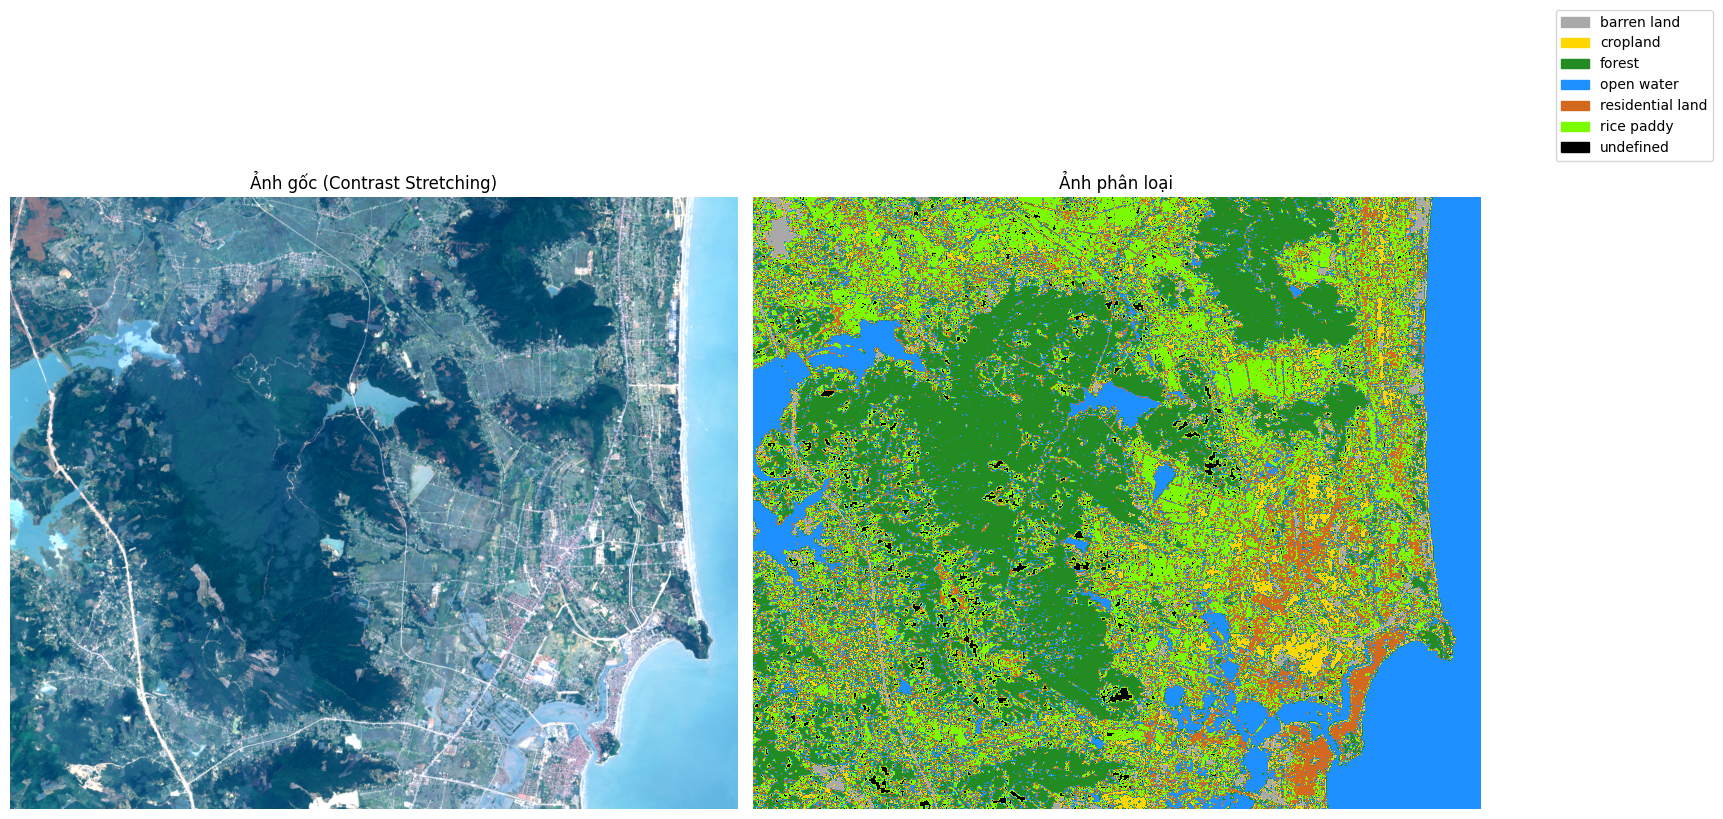

In [10]:
# Import các thư viện cần thiết
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # Thêm dòng này
from matplotlib.colors import ListedColormap, BoundaryNorm
from skimage import exposure


# Phần còn lại của code...
# Đường dẫn tới file ảnh vệ tinh
IMAGE_PATH = '/kaggle/input/testimg10/test.tif'

# Đọc ảnh vệ tinh
image = rasterio.open(IMAGE_PATH)

# Lấy thông tin ảnh
height = image.height
width = image.width
band_count = image.count

print(f'Image dimensions: {width} x {height}')
print(f'Number of bands: {band_count}')
# Tạo dictionary cho các band (loại bỏ B1)
band_indices = {
    'B2': 2, 'B3': 3, 'B4': 4, 'B5': 5, 'B6': 6, 'B7': 7, 'B8': 8,
    'B8A': 9, 'B9': 10, 'B10': 11, 'B11': 12, 'B12': 13
}

# Đọc các band cần thiết và tính toán các chỉ số
bands_data = {}
for feature in FEATURES:
    if feature in band_indices:
        # Đọc band từ ảnh
        band_data = image.read(band_indices[feature]).astype('float32')
        bands_data[feature] = band_data.flatten()
    elif feature == 'NDVI':
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B4 = image.read(band_indices['B4']).astype('float32').flatten()
        ndvi = (B8 - B4) / (B8 + B4 + 1e-8)
        bands_data[feature] = ndvi
    elif feature == 'NDWI':
        B3 = image.read(band_indices['B3']).astype('float32').flatten()
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        ndwi = (B3 - B8) / (B3 + B8 + 1e-8)
        bands_data[feature] = ndwi
    elif feature == 'NDBI':
        B11 = image.read(band_indices['B11']).astype('float32').flatten()
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        ndbi = (B11 - B8) / (B11 + B8 + 1e-8)
        bands_data[feature] = ndbi
    elif feature == 'NDMI':
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B11 = image.read(band_indices['B11']).astype('float32').flatten()
        ndmi = (B8 - B11) / (B8 + B11 + 1e-8)
        bands_data[feature] = ndmi
    elif feature == 'BSI':
        B11 = image.read(band_indices['B11']).astype('float32').flatten()
        B4 = image.read(band_indices['B4']).astype('float32').flatten()
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B2 = image.read(band_indices['B2']).astype('float32').flatten()
        bsi = ((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2) + 1e-8)
        bands_data[feature] = bsi
    elif feature == 'EVI':
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B4 = image.read(band_indices['B4']).astype('float32').flatten()
        B2 = image.read(band_indices['B2']).astype('float32').flatten()
        G = 2.5  # Gain factor
        C1 = 6.0  # Coefficient 1 for aerosol resistance
        C2 = 7.5  # Coefficient 2 for aerosol resistance
        L = 1.0  # Canopy background adjustment
        evi = G * (B8 - B4) / (B8 + C1 * B4 - C2 * B2 + L + 1e-8)
        bands_data[feature] = evi
    elif feature == 'SAVI':
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B4 = image.read(band_indices['B4']).astype('float32').flatten()
        L_savi = 0.5  # Soil adjustment factor
        savi = ((B8 - B4) * (1 + L_savi)) / (B8 + B4 + L_savi + 1e-8)
        bands_data[feature] = savi
    else:
        print(f"Chỉ số {feature} chưa được tính toán.")
# Tạo DataFrame cho image_input_data với tên cột
image_input_df = pd.DataFrame(bands_data, columns=FEATURES)

# Áp dụng scaler đã fit trên tập train
image_input_scaled = scaler.transform(image_input_df)
# Reshape dữ liệu
image_input = reshape_input(image_input_scaled)
# Dự đoán
batch_size = 8192
image_predictions = model.predict(image_input, batch_size=batch_size)

N_CLASSES = len(label_mapping) # Gán lại giá trị cho N_CLASSES
print(f"Giá trị của N_CLASSES trước khi thêm undefined: {N_CLASSES}") # In ra để kiểm tra

# Lấy nhãn dự đoán và xác suất
max_probs = np.max(image_predictions, axis=1)
pred_labels = np.argmax(image_predictions, axis=1)

# Gán nhãn 'undefined' (sử dụng một giá trị mới cho nhãn, ví dụ: N_CLASSES)
undefined_label = N_CLASSES  # Giả sử N_CLASSES hiện tại là 6, undefined_label sẽ là 6

# Tạo mảng nhãn mới, nếu max_prob < 0.8 thì gán undefined_label
pred_labels_with_undefined = np.where(max_probs < 0.8, undefined_label, pred_labels)

# Cập nhật N_CLASSES để bao gồm cả lớp 'undefined'
N_CLASSES += 1
print(f"Giá trị của N_CLASSES sau khi thêm undefined: {N_CLASSES}") # In ra để kiểm tra
# Bảng màu - Đảm bảo đủ màu cho N_CLASSES (7 màu trong trường hợp này)
PALETTE = ['#A9A9A9', '#FFD700', '#228B22', '#1E90FF', '#D2691E', '#7CFC00', '#000000']

# Tạo cmap và norm *sau* khi cập nhật N_CLASSES
cmap = ListedColormap(PALETTE)
norm = BoundaryNorm(range(N_CLASSES + 1), cmap.N)

# Reshape kết quả dự đoán
prediction_image = pred_labels_with_undefined.reshape((height, width))

# Tạo danh sách tên lớp
class_names = [label for label, index in label_mapping.items()] + ['undefined']

# Hiển thị ảnh
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Ảnh gốc với Contrast Stretching
band_red = image.read(4)
band_green = image.read(3)
band_blue = image.read(2)
rgb_image = np.dstack([band_red, band_green, band_blue])

p2, p98 = np.percentile(rgb_image, (2, 98))
rgb_image_contrast = exposure.rescale_intensity(rgb_image, in_range=(p2, p98))

axes[0].imshow(rgb_image_contrast)
axes[0].set_title("Ảnh gốc (Contrast Stretching)")
axes[0].axis('off')

# Ảnh phân loại
im = axes[1].imshow(prediction_image, cmap=cmap, norm=norm)
axes[1].set_title("Ảnh phân loại")
axes[1].axis('off')

# Chú thích
patches = [mpatches.Patch(color=PALETTE[i], label=class_names[i]) for i in range(N_CLASSES)]
fig.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()

Image dimensions: 474 x 308
Number of bands: 13
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Giá trị của N_CLASSES trước khi thêm undefined: 7
Giá trị của N_CLASSES trước khi thêm undefined: 6
Giá trị của N_CLASSES sau khi thêm undefined: 7


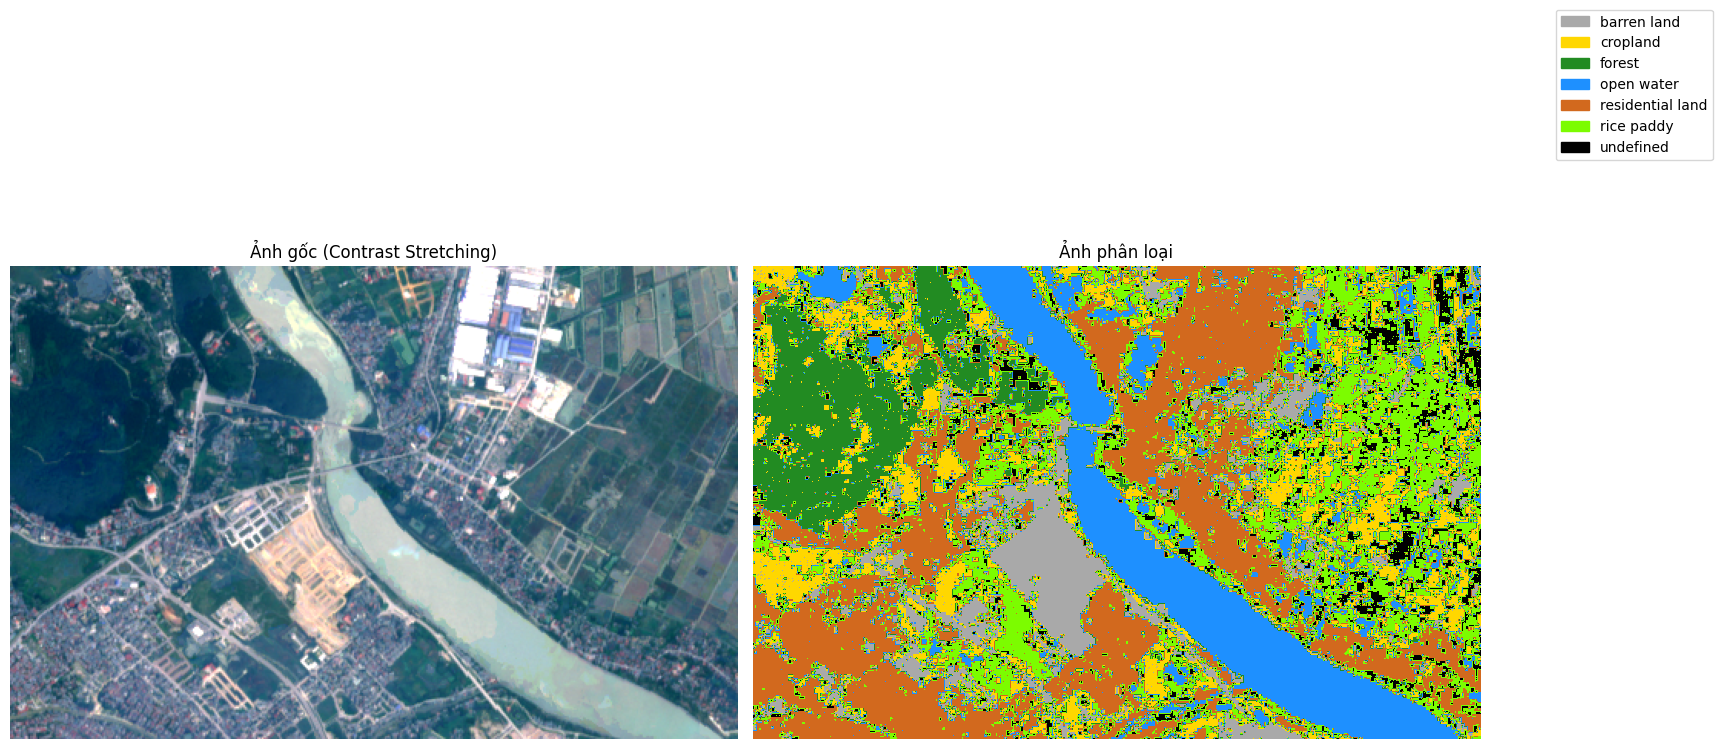

In [13]:
# Import các thư viện cần thiết
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # Thêm dòng này
from matplotlib.colors import ListedColormap, BoundaryNorm
from skimage import exposure


# Phần còn lại của code...
# Đường dẫn tới file ảnh vệ tinh
IMAGE_PATH = '/kaggle/input/predict-image/hehee.tif'

# Đọc ảnh vệ tinh
image = rasterio.open(IMAGE_PATH)

# Lấy thông tin ảnh
height = image.height
width = image.width
band_count = image.count

print(f'Image dimensions: {width} x {height}')
print(f'Number of bands: {band_count}')
# Tạo dictionary cho các band (loại bỏ B1)
band_indices = {
    'B2': 2, 'B3': 3, 'B4': 4, 'B5': 5, 'B6': 6, 'B7': 7, 'B8': 8,
    'B8A': 9, 'B9': 10, 'B10': 11, 'B11': 12, 'B12': 13
}

# Đọc các band cần thiết và tính toán các chỉ số
bands_data = {}
for feature in FEATURES:
    if feature in band_indices:
        # Đọc band từ ảnh
        band_data = image.read(band_indices[feature]).astype('float32')
        bands_data[feature] = band_data.flatten()
    elif feature == 'NDVI':
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B4 = image.read(band_indices['B4']).astype('float32').flatten()
        ndvi = (B8 - B4) / (B8 + B4 + 1e-8)
        bands_data[feature] = ndvi
    elif feature == 'NDWI':
        B3 = image.read(band_indices['B3']).astype('float32').flatten()
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        ndwi = (B3 - B8) / (B3 + B8 + 1e-8)
        bands_data[feature] = ndwi
    elif feature == 'NDBI':
        B11 = image.read(band_indices['B11']).astype('float32').flatten()
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        ndbi = (B11 - B8) / (B11 + B8 + 1e-8)
        bands_data[feature] = ndbi
    elif feature == 'NDMI':
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B11 = image.read(band_indices['B11']).astype('float32').flatten()
        ndmi = (B8 - B11) / (B8 + B11 + 1e-8)
        bands_data[feature] = ndmi
    elif feature == 'BSI':
        B11 = image.read(band_indices['B11']).astype('float32').flatten()
        B4 = image.read(band_indices['B4']).astype('float32').flatten()
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B2 = image.read(band_indices['B2']).astype('float32').flatten()
        bsi = ((B11 + B4) - (B8 + B2)) / ((B11 + B4) + (B8 + B2) + 1e-8)
        bands_data[feature] = bsi
    elif feature == 'EVI':
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B4 = image.read(band_indices['B4']).astype('float32').flatten()
        B2 = image.read(band_indices['B2']).astype('float32').flatten()
        G = 2.5  # Gain factor
        C1 = 6.0  # Coefficient 1 for aerosol resistance
        C2 = 7.5  # Coefficient 2 for aerosol resistance
        L = 1.0  # Canopy background adjustment
        evi = G * (B8 - B4) / (B8 + C1 * B4 - C2 * B2 + L + 1e-8)
        bands_data[feature] = evi
    elif feature == 'SAVI':
        B8 = image.read(band_indices['B8']).astype('float32').flatten()
        B4 = image.read(band_indices['B4']).astype('float32').flatten()
        L_savi = 0.5  # Soil adjustment factor
        savi = ((B8 - B4) * (1 + L_savi)) / (B8 + B4 + L_savi + 1e-8)
        bands_data[feature] = savi
    else:
        print(f"Chỉ số {feature} chưa được tính toán.")
# Tạo DataFrame cho image_input_data với tên cột
image_input_df = pd.DataFrame(bands_data, columns=FEATURES)

# Áp dụng scaler đã fit trên tập train
image_input_scaled = scaler.transform(image_input_df)
# Reshape dữ liệu
image_input = reshape_input(image_input_scaled)
# Dự đoán
batch_size = 8192
image_predictions = model.predict(image_input, batch_size=batch_size)
print(f"Giá trị của N_CLASSES trước khi thêm undefined: {N_CLASSES}") 

N_CLASSES = len(label_mapping) # Gán lại giá trị cho N_CLASSES
print(f"Giá trị của N_CLASSES trước khi thêm undefined: {N_CLASSES}") # In ra để kiểm tra

# Lấy nhãn dự đoán và xác suất
max_probs = np.max(image_predictions, axis=1)
pred_labels = np.argmax(image_predictions, axis=1)

# Gán nhãn 'undefined' (sử dụng một giá trị mới cho nhãn, ví dụ: N_CLASSES)
undefined_label = N_CLASSES  # Giả sử N_CLASSES hiện tại là 6, undefined_label sẽ là 6

# Tạo mảng nhãn mới, nếu max_prob < 0.8 thì gán undefined_label
pred_labels_with_undefined = np.where(max_probs < 0.7, undefined_label, pred_labels)

# Cập nhật N_CLASSES để bao gồm cả lớp 'undefined'
N_CLASSES += 1
print(f"Giá trị của N_CLASSES sau khi thêm undefined: {N_CLASSES}") # In ra để kiểm tra
# Bảng màu - Đảm bảo đủ màu cho N_CLASSES (7 màu trong trường hợp này)
PALETTE = ['#A9A9A9', '#FFD700', '#228B22', '#1E90FF', '#D2691E', '#7CFC00', '#000000']

# Tạo cmap và norm *sau* khi cập nhật N_CLASSES
cmap = ListedColormap(PALETTE)
norm = BoundaryNorm(range(N_CLASSES + 1), cmap.N)

# Reshape kết quả dự đoán
prediction_image = pred_labels_with_undefined.reshape((height, width))

# Tạo danh sách tên lớp
class_names = [label for label, index in label_mapping.items()] + ['undefined']

# Hiển thị ảnh
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Ảnh gốc với Contrast Stretching
band_red = image.read(4)
band_green = image.read(3)
band_blue = image.read(2)
rgb_image = np.dstack([band_red, band_green, band_blue])

p2, p98 = np.percentile(rgb_image, (2, 98))
rgb_image_contrast = exposure.rescale_intensity(rgb_image, in_range=(p2, p98))

axes[0].imshow(rgb_image_contrast)
axes[0].set_title("Ảnh gốc (Contrast Stretching)")
axes[0].axis('off')

# Ảnh phân loại
im = axes[1].imshow(prediction_image, cmap=cmap, norm=norm)
axes[1].set_title("Ảnh phân loại")
axes[1].axis('off')

# Chú thích
patches = [mpatches.Patch(color=PALETTE[i], label=class_names[i]) for i in range(N_CLASSES)]
fig.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()
plt.show()